In [1]:
%matplotlib inline
from utils import read, createGraph, genders, functionals
import networkx as nx
from glob import iglob as glob
from os.path import exists, basename
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
import numpy as np
import scipy as sp

plt.rcParams["figure.figsize"] = (10, 8)

In [2]:
th = 2
data_dir = "./data/by_movie/*"
info_dir = "./data/speakersWithCharacterInfo/"

## Read all scripts

In [3]:
data, chars = {}, {}
for script in glob(data_dir):
    try:
        char_list, adj = read(script, threshold = th)
        
        gender_file = info_dir + basename(script).replace(".", "_") + ".txt"
        if exists(gender_file):
            gens = genders(gender_file)
        else:
            gens = defaultdict(lambda: 'unknown')
        
        G = createGraph(char_list, adj, gens)
           
        data[basename(script)] = G
        chars[basename(script)] = char_list
    except:
        pass

# Pre-check
In [GENDER BIAS WITHOUT BORDERS](http://seejane.org/wp-content/uploads/gender-bias-without-borders-executive-summary.pdf), there is a ratio of 2.25 men for every women on screen (women = $30.9$%). Lets check our numbers.

In [4]:
total, males, females = 0, 0, 0
for _, G in data.items():
    for i in G.nodes():
        if G.node[i]['gender'] == 'male':
            males += 1
        elif G.node[i]['gender'] == 'female':
            females += 1
        
        total += 1
        
print("total: {}".format(total))
print("males: {:.2f}%".format(float(males) / total))
print("females: {:.2f}%".format(float(females) / total))


total: 14456
males: 0.37%
females: 0.16%


What if we drop unknown?... shouldn't matter right?

In [5]:
print("males: {:.2f}%".format(float(males) / (males + females)))
print("females: {:.2f}%".format(float(females) / (males + females)))

males: 0.70%
females: 0.30%


# Graph analysis

### Degree centrality

#### Average degree

In [6]:
male_deg, female_deg = [], []
for script, G in data.items():
    degrees = nx.degree(G)
    
    male_deg.append(np.mean([degrees[i] for i in G.nodes() if G.node[i]['gender'] == 'male']))
    female_deg.append(np.mean([degrees[i] for i in G.nodes() if G.node[i]['gender'] == 'female']))

/Users/victor/miniconda2/envs/py3k/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


/Users/victor/miniconda2/envs/py3k/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


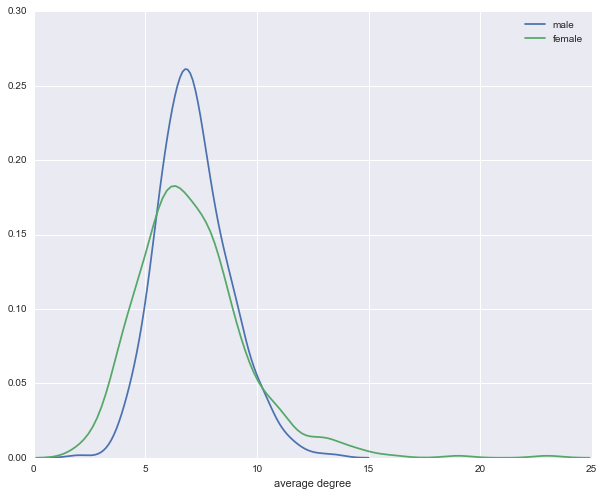

In [7]:
sns.distplot(male_deg, hist = False, label = "male");
sns.distplot(female_deg, hist = False, label = "female");
plt.legend();
plt.xlabel("average degree");

There is no real difference in the number of connections between men and women.

In [8]:
#Remove nans
male_deg, female_deg = np.array(male_deg), np.array(female_deg)
male_deg = male_deg[~np.isnan(male_deg)]
female_deg = female_deg[~np.isnan(female_deg)]


sp.stats.ttest_ind(male_deg, female_deg)

Ttest_indResult(statistic=0.66854780460708829, pvalue=0.50394934333620589)

### Betweeness Centrality

#### Average centrality

In [9]:
male_cent, female_cent = [], []
for script, G in data.items():
    cents = nx.betweenness_centrality(G)
    
    male_cent.append(np.mean([cents[i] for i in G.nodes() if G.node[i]['gender'] == 'male']))
    female_cent.append(np.mean([cents[i] for i in G.nodes() if G.node[i]['gender'] == 'female']))

/Users/victor/miniconda2/envs/py3k/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


Just a quick note, this is a _density_, not a probability. The AUC adds up to 1. 

/Users/victor/miniconda2/envs/py3k/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


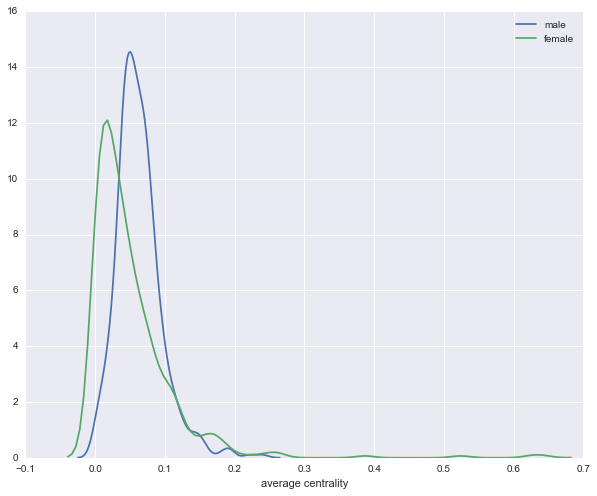

In [10]:
sns.distplot(male_cent, hist = False, label = "male");
sns.distplot(female_cent, hist = False, label = "female");
plt.legend();
plt.xlabel("average centrality");

In this case, there is a significant difference in the average centrality of male characters and female characters ($t(?) = 2.7951,\, p < 0.01$). In most of the scripts, males occupy a more central role than females.

In [11]:
#Remove nans
male_cent, female_cent = np.array(male_cent), np.array(female_cent)
male_cent = male_cent[~np.isnan(male_cent)]
female_cent = female_cent[~np.isnan(female_cent)]


sp.stats.ttest_ind(male_cent, female_cent)

Ttest_indResult(statistic=3.2939679380839992, pvalue=0.0010250046869674631)

### Who are the most central women?

In [12]:
female_cent = []
for script, G in data.items():
    cents = nx.betweenness_centrality(G)

    char_list = chars[script]
    
    for femme in G.nodes():
        if G.node[femme]['gender'] == 'female':
            female_cent.append((script, char_list[femme], cents[femme]))

Top 15 movies with the most central female lead. We got Sarah Connor and Erin Bronckovich!

In [13]:
sorted(female_cent, key = lambda x: x[2], reverse = True)[:15]

[('terminator.xml', 'SARAH', 0.7836257309941519),
 ('frances.xml', 'FRANCES', 0.7700442967884829),
 ('8mm.xml', 'WELLES', 0.7641325536062379),
 ('music_of_the_heart.xml', 'ROBERTA', 0.7591068279163516),
 ('agnes_of_god.xml', 'MARTHA', 0.75),
 ('ringu.xml', 'ASAKAWA', 0.7352941176470589),
 ('erin_brockovich.xml', 'ERIN', 0.7330447330447329),
 ('high_fidelity.xml', 'ROB', 0.7241666666666666),
 ('precious.xml', 'PRECIOUS', 0.7236842105263157),
 ('what_lies_beneath.xml', 'CLAIRE', 0.7158119658119657),
 ('bridesmaids.xml', 'ANNIE', 0.7103081232492997),
 ('wind_chill.xml', 'GIRL', 0.6428571428571428),
 ('charade.xml', 'REGGIE', 0.6253246753246753),
 ('juno.xml', 'JUNO', 0.6034798534798536),
 ('legally_blonde.xml', 'ELLE', 0.6031476050830891)]

# Triads and love triangles
Can we say that love triangles are really that common?

In [14]:
def countTrianglesByGender(G):
    triangles = []

    for i in G.nodes():
        for j in G.neighbors(i):
            if j == i:
                continue 

            for k in G.neighbors(j):
                if k == j or k == i:
                    continue

                if i in G.neighbors(k):
                    triangles.append(tuple(sorted([i, j, k])))

    triangles = set(triangles)
    triangles_genders = map(lambda x: map(lambda _: G.node[_]['gender'], x), triangles)
    
    return Counter(list(map(lambda x: tuple(sorted(list(x))), triangles_genders)))

Same gender triangles are the least common!! 

In [15]:
genderTriangs = sum(map(countTrianglesByGender, data.values()), Counter())
genderTriangs

Counter({('female', 'female', 'female'): 585,
         ('female', 'female', 'male'): 3096,
         ('female', 'female', 'unknown'): 640,
         ('female', 'male', 'male'): 7587,
         ('female', 'male', 'unknown'): 3438,
         ('female', 'unknown', 'unknown'): 583,
         ('male', 'male', 'male'): 6288,
         ('male', 'male', 'unknown'): 4720,
         ('male', 'unknown', 'unknown'): 1744,
         ('unknown', 'unknown', 'unknown'): 9381})